In [3]:
# The Python standard library import
import numpy as np
import sys
import os
import shutil
from pathlib import Path
print(str(Path().resolve()))
current_dir = str(Path().resolve())
sys.path.append(os.path.join(current_dir, '..'))

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from operator import attrgetter


# The NEAT-Python library imports
import modneat
# The helper used to visualize experiment results
from modneat import visualize

/home/kato-masahiro/Project/velocity_2ol


In [79]:
checkpoint_path = '/home/kato-masahiro/Project/velocity_2ol/results2023_3_4/task_lv3/[CONTINUED]velocity_task.velocity_task_N_ModExHebbFFN_lv2/checkpoints/checkpoint-9999'

p = modneat.Checkpointer.restore_checkpoint(checkpoint_path)
p.config.genome_config.enabled_mutate_rate
population_list = list(p.population.values())
population_list = sorted(population_list, key=attrgetter('fitness'))
best_individual = population_list[-1]

In [148]:
print(best_individual)

Key: 56709
Fitness: -0.20352627774596327
Nodes:
	0 ModNodeGene(key=0, bias=-2.1522769955914627, response=1.0, activation=sigmoid, aggregation=sum, modulatory=False)
Connections:
	DefaultConnectionGene(key=(-1, 0), weight=4.323199953552936, enabled=True)
Global params:
	ExHebbGlobalGene(key=0, eta=0.37239327289199053, a=5.142743939216801, b=-1.5210608713727047, c=0.7527424829453152, d=0.049243542151038815, m_d=0.0)


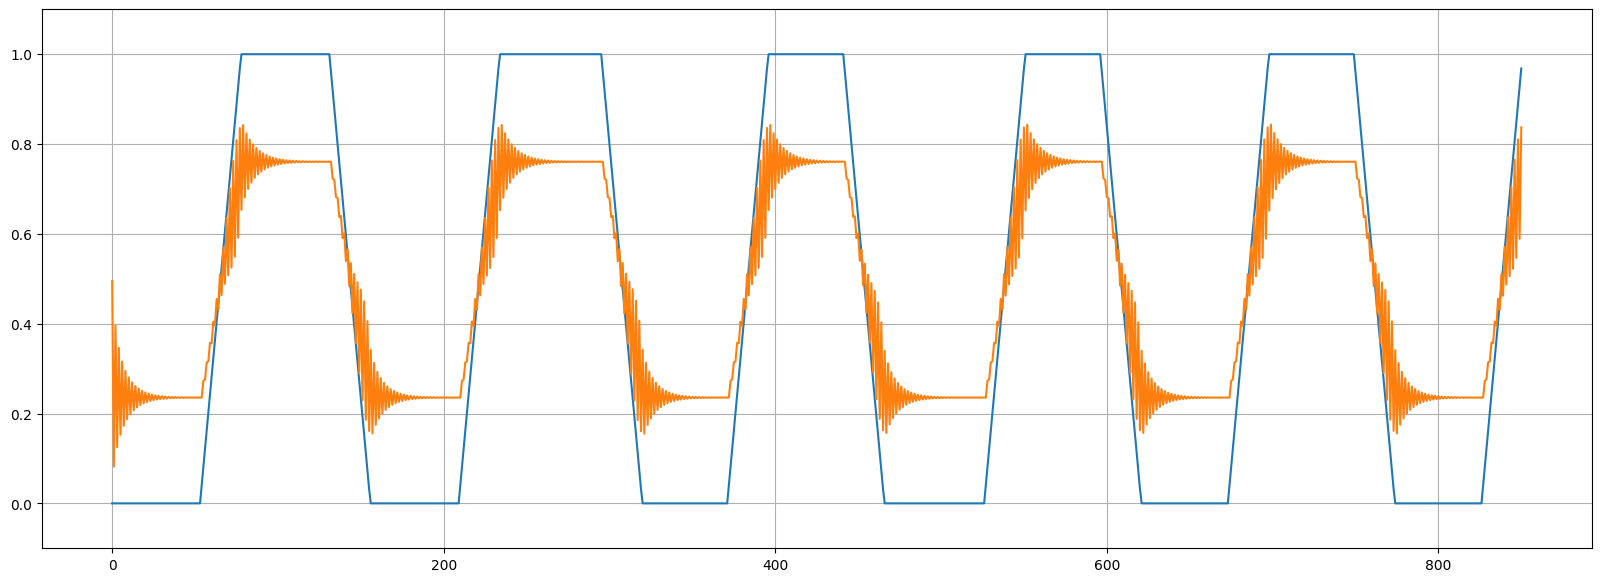

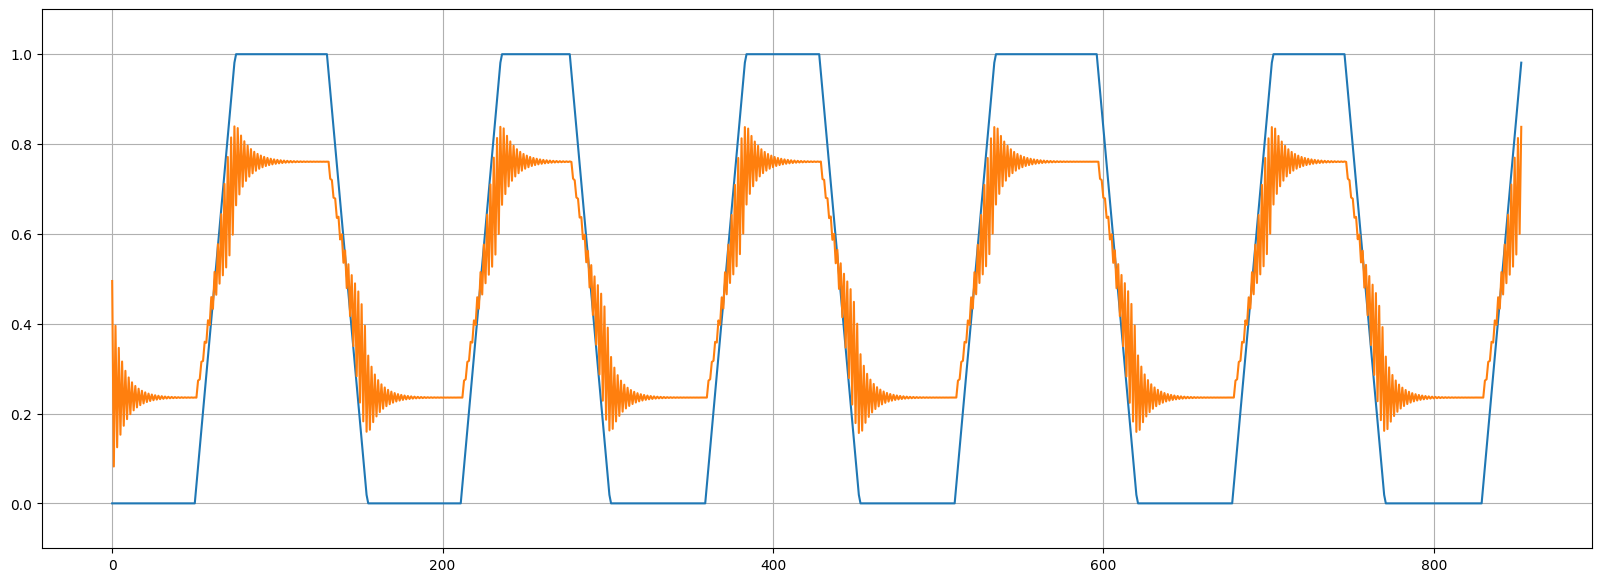

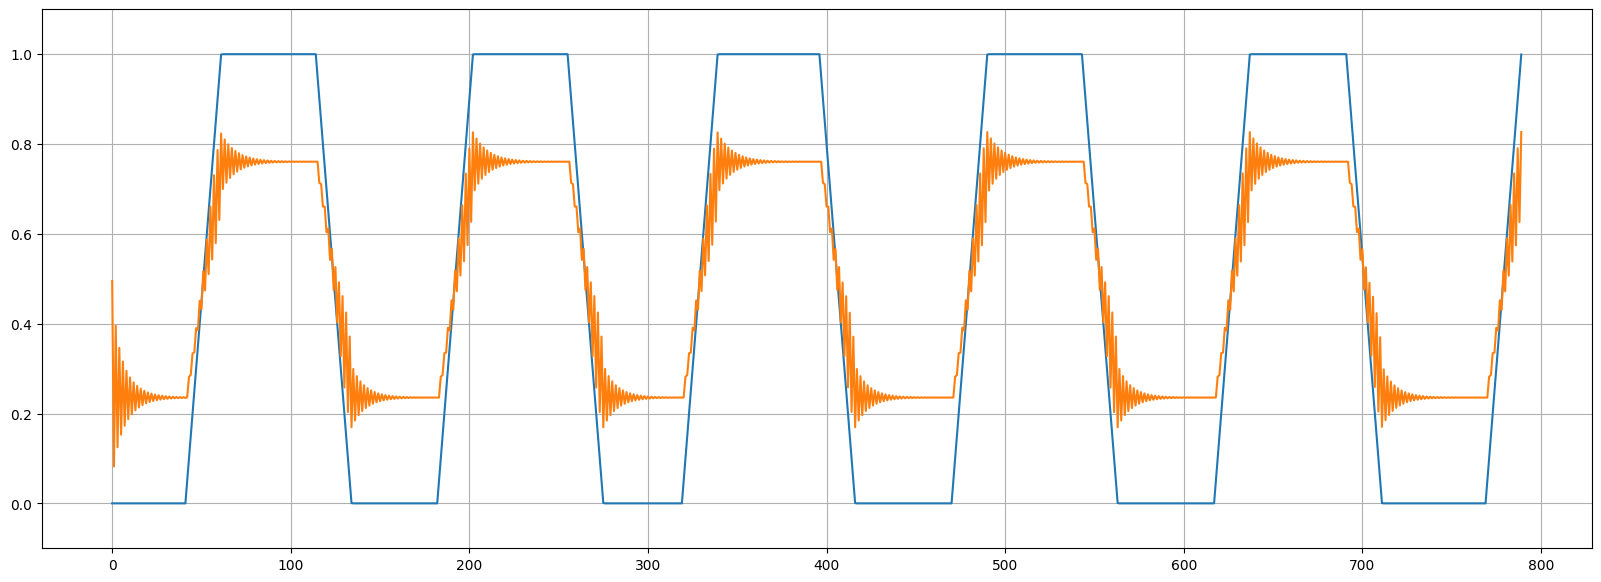

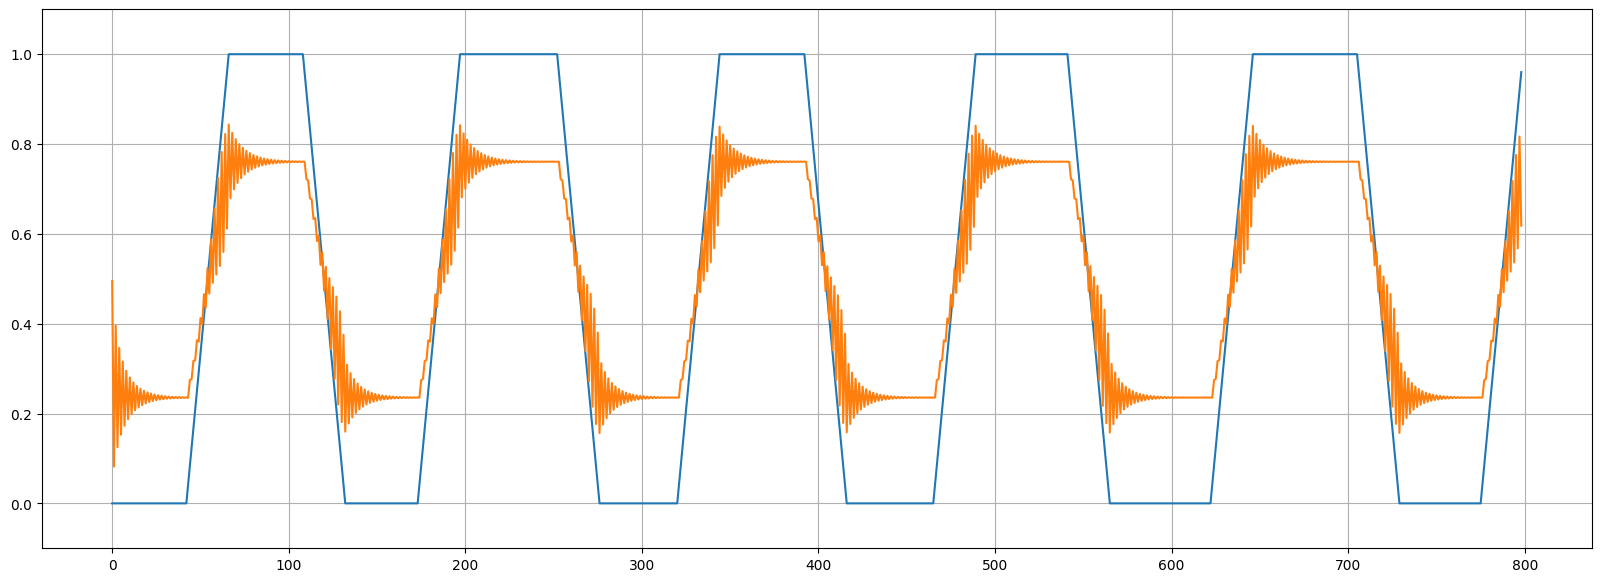

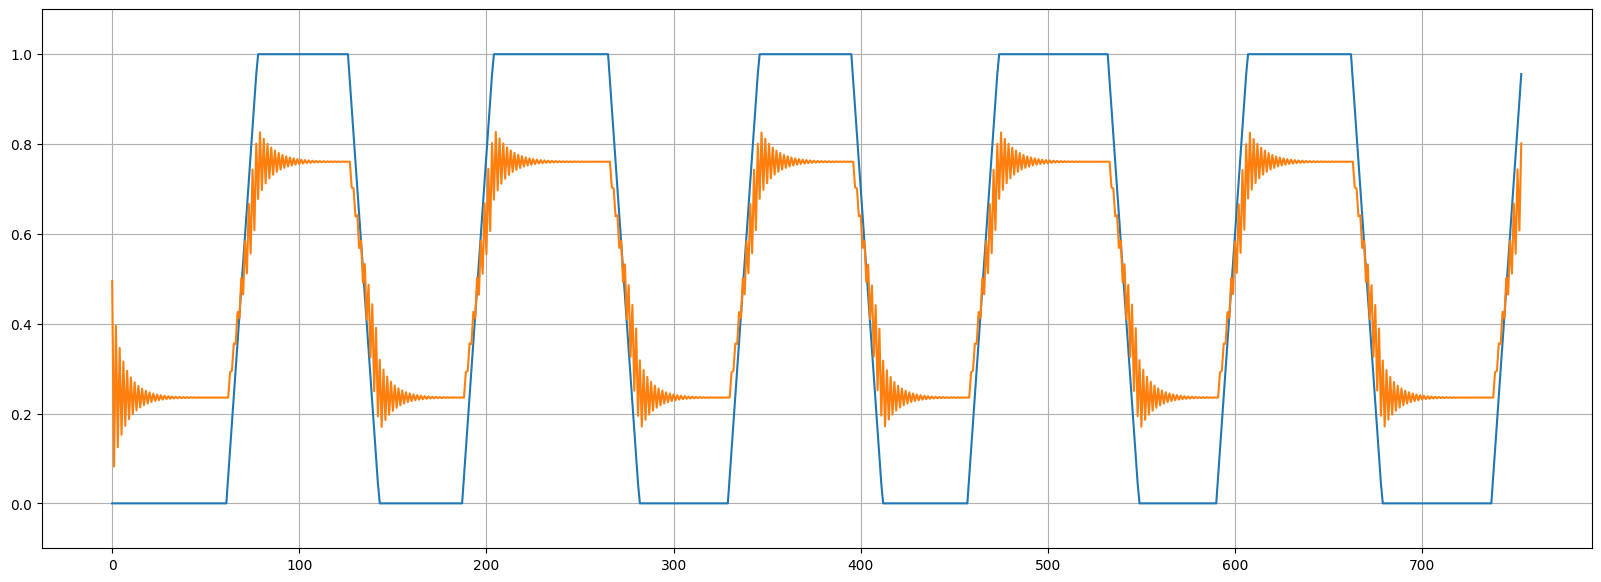

In [59]:
#print(best_individual.history)

for loop_list in best_individual.history:
    target_list = [d['target'] for d in loop_list]
    output_list = [d['output'][0] for d in loop_list]
    input_list = [d['input'] for d in loop_list]
    xlabel = [n for n in range(len(input_list))]
    #print(target_list)
    #print(output_list)
    fig = plt.figure(figsize=(20,7))
    plt.plot(xlabel, target_list)
    plt.plot(xlabel, output_list)
    #plt.plot(xlabel, input_list)
    plt.ylim(-0.1,1.1)
    plt.grid()
    plt.show()

---


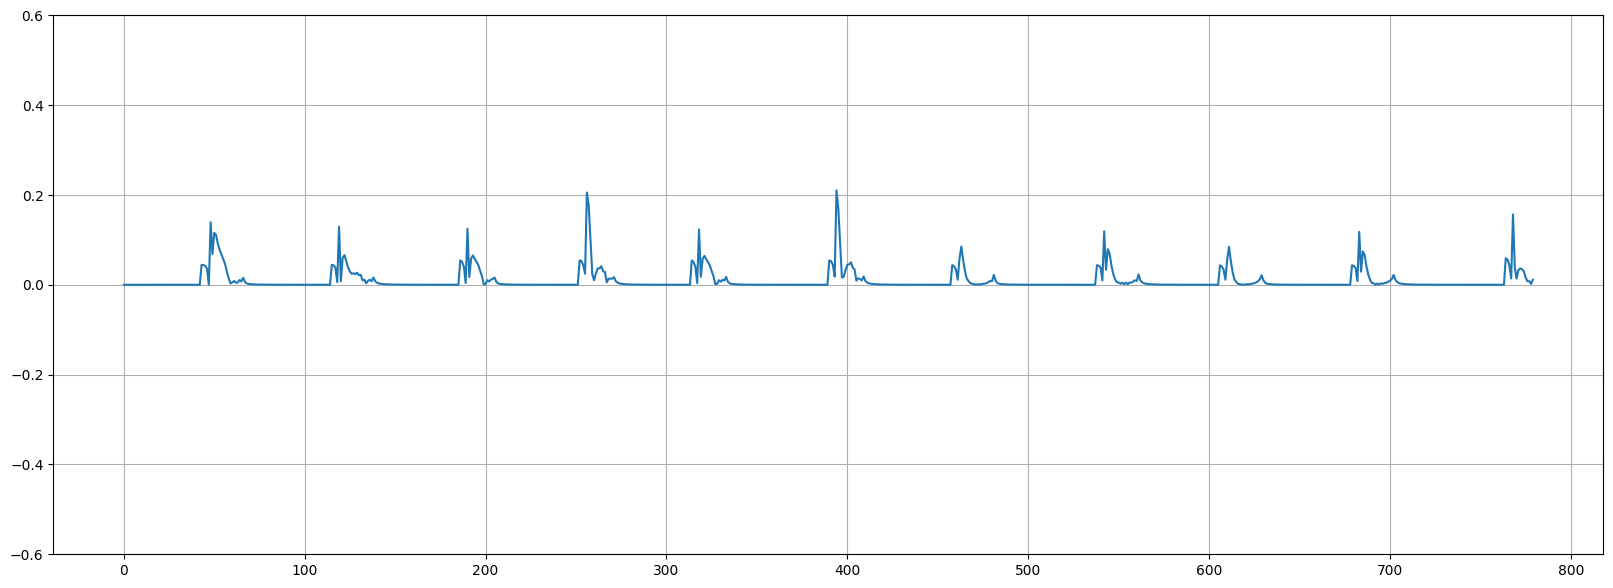

---


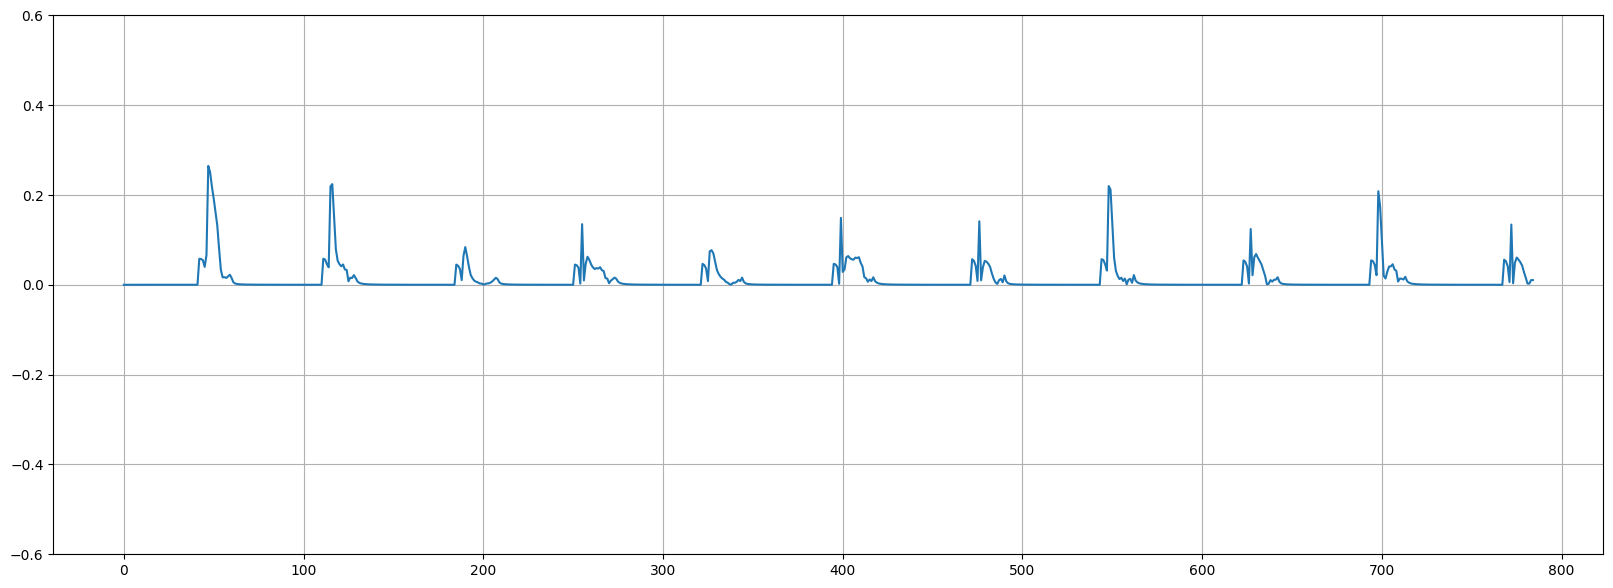

---


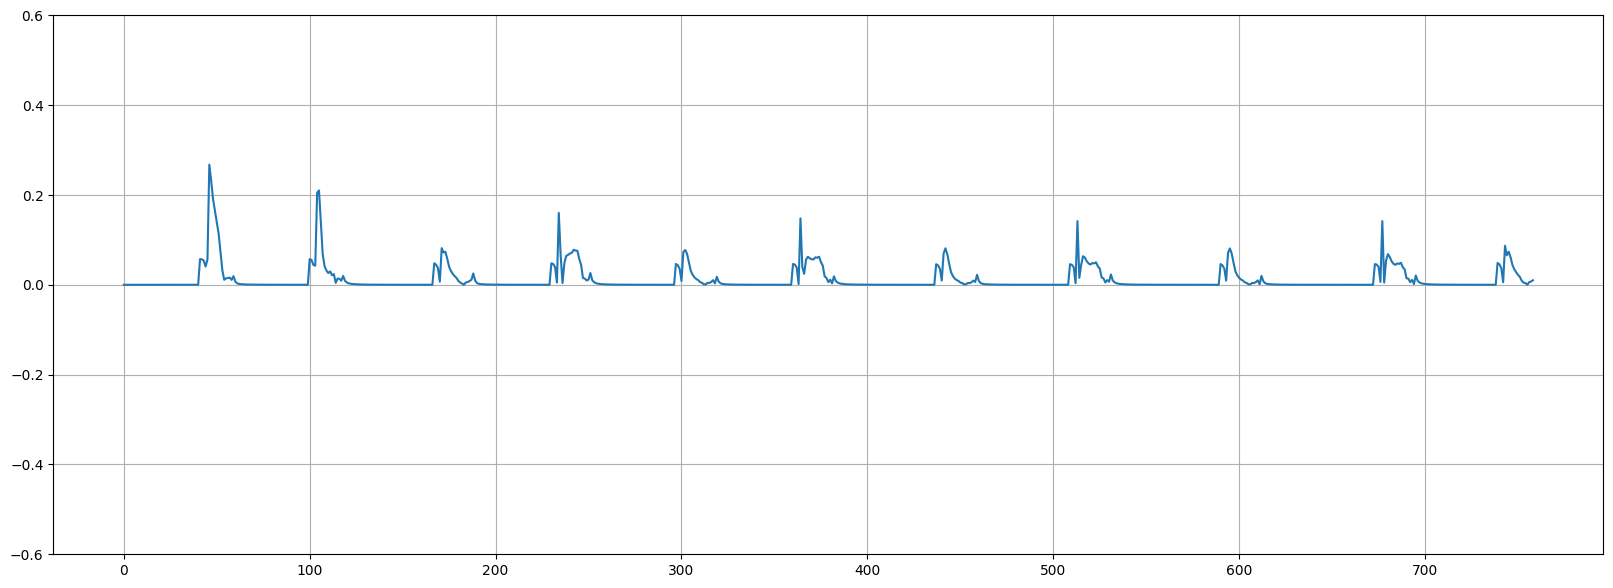

---


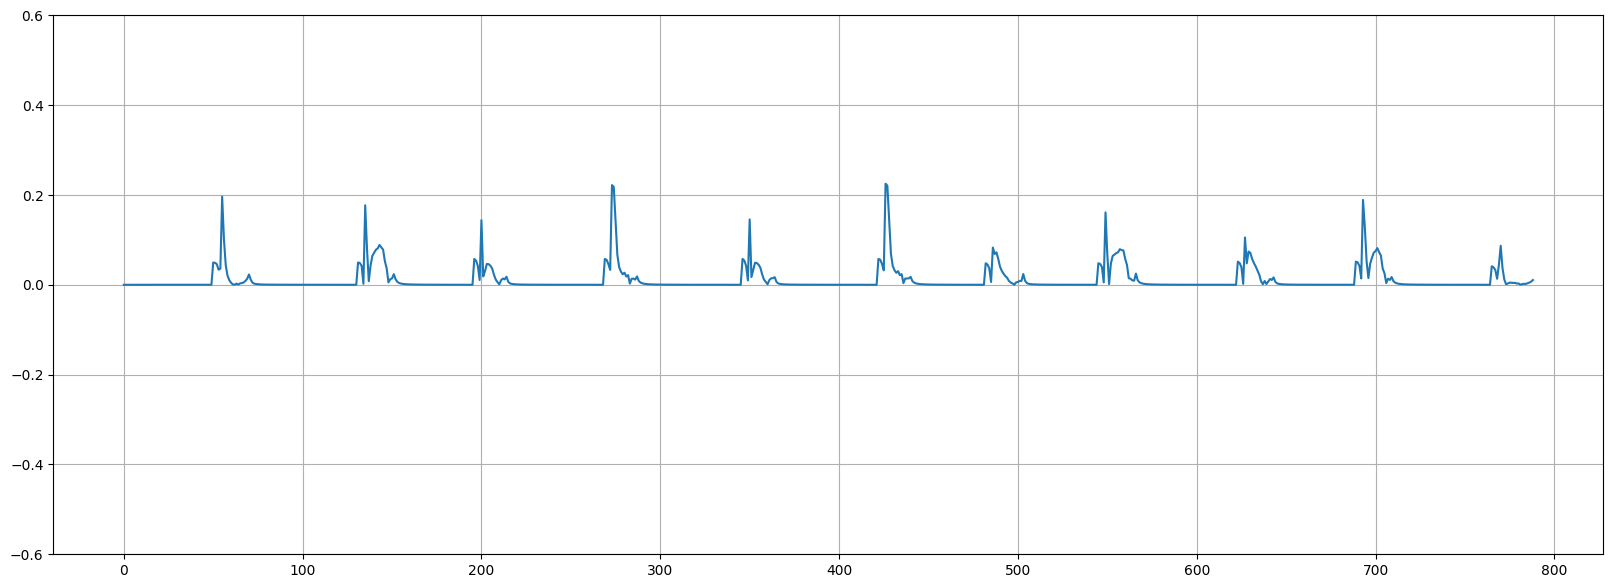

---


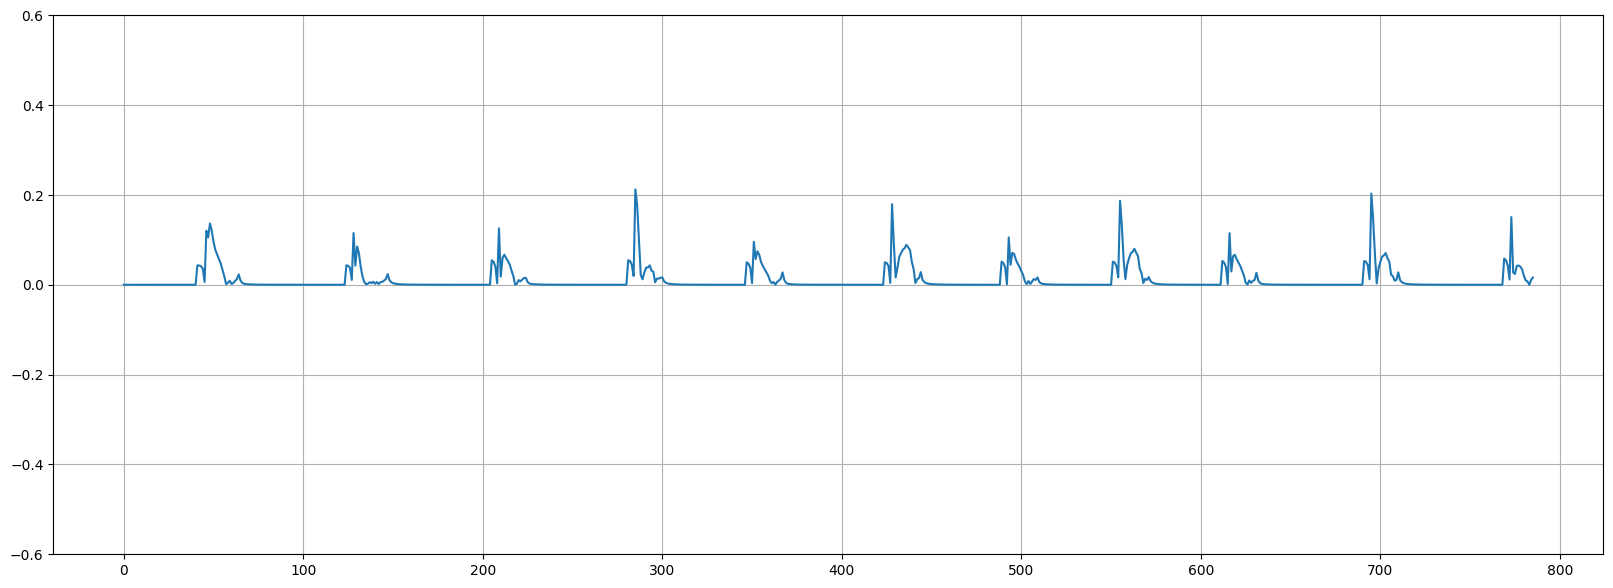

In [80]:
# モデルの学習効果、学習速度を可視化
for loop_list in best_individual.history:
    target_list = [d['target'] for d in loop_list]
    output_list = [d['output'][0] for d in loop_list]
    input_list = [d['input'] for d in loop_list]

    ideal_diff_list = []
    for i in range(len(target_list) -1):
        ideal_diff_list.append(target_list[i+1] - target_list[i])

    actual_diff_list = []
    for i in range(len(output_list) -1):
        actual_diff_list.append(output_list[i+1] - output_list[i])

    diff_diff_list = []
    for i in range(len(ideal_diff_list)):
        diff_diff_list.append(abs(ideal_diff_list[i] - actual_diff_list[i]))
    #print(ideal_diff_list)
    #print(actual_diff_list)
    #print(diff_diff_list)
    print("---")
    xlabel = [n for n in range(len(input_list) -1)]
    #print(target_list)
    #print(output_list)
    fig = plt.figure(figsize=(20,7))
    plt.plot(xlabel, diff_diff_list)
    #plt.plot(xlabel, actual_diff_list)
    #plt.plot(xlabel, ideal_diff_list)
    plt.ylim(-0.6,0.6)
    plt.grid()
    plt.show()

In [73]:
# 二次学習能力(長期)
#学習能力が長期的に(生涯スケールで)どの程度改良されていくかを定量化したもの
e_list=[]
for loop_list in best_individual.history:

    # historyから各要素のリストを作成する
    target_list = [d['target'] for d in loop_list]
    output_list = [d['output'][0] for d in loop_list]
    input_list = [d['input'] for d in loop_list]

    # 理想的な行動変化を示すリストを作成
    ideal_diff_list = []
    for i in range(len(target_list) -1):
        ideal_diff_list.append(target_list[i+1] - target_list[i])

    # 実際のエージェントの行動変化を示すリストを作成
    actual_diff_list = []
    for i in range(len(output_list) -1):
        actual_diff_list.append(output_list[i+1] - output_list[i])

    # 理想リストと実際のリストの差を作成
    diff_diff_list = []
    for i in range(len(ideal_diff_list)):
        diff_diff_list.append(abs(ideal_diff_list[i] - actual_diff_list[i]))
    
    # diff_range_listとして、変動が開始したステップ数を要素として持つリストを作成
    tmp_list=[]
    for i in range(len(ideal_diff_list)):
        if not(ideal_diff_list[i] == 0 or ideal_diff_list[i] == 1):
            tmp_list.append(i)
    tmp_list.append(len(ideal_diff_list))
    diff_range_list = []
    diff_range_list.append(tmp_list[0])
    for i in range(len(tmp_list) -1):
        if not( abs(tmp_list[i] - tmp_list[i+1]) == 1):
            diff_range_list.append(tmp_list[i])
            diff_range_list.append(tmp_list[i+1])
    diff_range_list.append(tmp_list[-1])
    
    print(diff_range_list)

    # resultとして、変動幅([開始ステップ、終了ステップ] のリスト)を要素として持つリストを作成
    result=[]
    for i in range(0, len(diff_range_list) -1 , 2):
        result.append([diff_range_list[i], diff_range_list[i+1]])
    
    print(result)
    # resultを利用していろいろ可視化
    partial_diff_list = []
    long_term_2ol_effect = []
    for pair in (result):
        #print(ideal_diff_list[pair[0]:pair[1]])
        #print(actual_diff_list[pair[0]:pair[1]])

        # 長期的な二次学習の効果を可視化
        long_term_2ol_effect.append(sum(diff_diff_list[pair[0]:pair[1]]))

        # 短期的な二次学習の効果を可視化
        short_term_2ol_effect = diff_diff_list[pair[0]:pair[1]]
        short_term_actual = actual_diff_list[pair[0]:pair[1]]
        short_term_ideal = ideal_diff_list[pair[0]:pair[1]]
        # 移動平均を求める
        df = pd.DataFrame(short_term_2ol_effect, columns=['value'])
        ma = df['value'].rolling(window=3).mean()

        #xlabel = [n for n in range (len(short_term_2ol_effect))]
        #fig = plt.figure(figsize=(4,4))
        #plt.plot(xlabel, short_term_ideal)
        #plt.plot(xlabel, short_term_actual)
        #plt.plot(xlabel, short_term_2ol_effect)
        #plt.plot(xlabel, ma)
        #plt.ylim(-0.,0.1)
        #plt.grid()
        #plt.show()
    
    sum_e=[]
    for i in range(len(long_term_2ol_effect) -1):
        sum_e.append(long_term_2ol_effect[i+1] / long_term_2ol_effect[i])
    
    e = (sum(sum_e) / len(sum_e))
    print(sum_e)
    e_list.append(e)
print('最終結果:', sum(e_list)/len(e_list))

[43, 65, 115, 137, 186, 204, 252, 270, 314, 332, 390, 408, 458, 480, 538, 560, 606, 629, 679, 702, 764, 780]
[[43, 65], [115, 137], [186, 204], [252, 270], [314, 332], [390, 408], [458, 480], [538, 560], [606, 629], [679, 702], [764, 780]]
[0.6893838734663786, 0.9232711725896163, 1.41640082801134, 0.6982332418651067, 1.4866436946375456, 0.43522394840042944, 1.3608508425019556, 0.7229216228655552, 1.335816817206154, 1.0250503180927661]
[42, 59, 111, 128, 185, 207, 251, 273, 322, 343, 395, 416, 472, 489, 544, 561, 623, 641, 694, 712, 768, 785]
[[42, 59], [111, 128], [185, 207], [251, 273], [322, 343], [395, 416], [472, 489], [544, 561], [623, 641], [694, 712], [768, 785]]
[0.6913825371289132, 0.4133803952179548, 1.6389113700641702, 0.6955003229600204, 1.7586099280965948, 0.6347967590662404, 1.5413019556557808, 0.7076660602765684, 1.409380082438237, 0.6633260405644994]
[41, 58, 100, 117, 167, 187, 230, 250, 297, 318, 360, 381, 437, 458, 509, 530, 590, 611, 673, 694, 739, 759]
[[41, 58], [

In [211]:

# 行動、行動の微分、行動の二回微分の概念を利用して各効果を定量化
# 二次学習能力(長期)
#学習能力が長期的に(生涯スケールで)どの程度改良されていくかを定量化したもの

def total_diff(list1, list2):
    sum = 0
    for n in range(len(list1)):
        sum += abs(list1[n] - list2[n])
    return sum

a_list = []
l1_list = []
l2_list = []
for loop_list in best_individual.history:

    # historyから各要素のリストを作成する
    target_list = [d['target'] for d in loop_list]
    output_list = [d['output'][0] for d in loop_list]
    input_list = [d['input'] for d in loop_list]

    d_target_list = [ target_list[i+1] - target_list[i] for i in range(len(target_list) -1)]
    dd_target_list = [ d_target_list[i+1] - d_target_list[i] for i in range(len(d_target_list) -1)]
    
    d_output_list = [ output_list[i+1] - output_list[i] for i in range(len(output_list) -1)]
    dd_output_list = [ d_output_list[i+1] - d_output_list[i] for i in range(len(d_output_list) -1)]

    test_score = total_diff([1,2,3,4,5], [1,2,3,4,5])
    action_score = total_diff(target_list, output_list)
    l_score = total_diff(d_target_list, d_output_list)
    l2_score = total_diff(dd_target_list, dd_output_list)

    a_list.append(action_score)
    l1_list.append(l_score)
    l2_list.append(l2_score)
    
    xlabel = [n for n in range (len(target_list))]
    fig = plt.figure(figsize=(12,4))

    plt.plot(xlabel, target_list)
    #plt.plot(xlabel, output_list)
    plt.plot(xlabel[1:], d_target_list)
    #plt.plot(xlabel[1:], d_output_list)
    #plt.plot(xlabel[2:], dd_output_list)
    plt.plot(xlabel[2:], dd_target_list)
    plt.ylim(-0.1,0.2)
    plt.grid()
    plt.show()

print(sum(a_list) / len(a_list))
print(sum(l1_list) / len(l1_list))
print(sum(l2_list) / len(l2_list)) 

11.69210588058059
6.548143424026098
9.805424620068141


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>